In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score, accuracy_score
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Embedding, SimpleRNN, Dense, Dropout, TextVectorization, Bidirectional
import pandas as pd
import tensorflow as tf
import random
import os

# RNN #
### Load Data

In [6]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


train_df = pd.read_csv('../data/train.csv', dtype={'text': str, 'label': str})
val_df = pd.read_csv('../data/valid.csv', dtype={'text': str, 'label': str})
test_df = pd.read_csv('../data/test.csv', dtype={'text': str, 'label': str})

train_texts = train_df['text'].astype(str).tolist()
train_labels = train_df['label'].astype(str).tolist()

val_texts = val_df['text'].astype(str).tolist()
val_labels = val_df['label'].astype(str).tolist()

test_texts = test_df['text'].astype(str).tolist()
test_labels = test_df['label'].astype(str).tolist()

# Clean texts if theres any NaN or empty strings
train_texts = [text if text and not pd.isna(text) else "" for text in train_texts]
val_texts = [text if text and not pd.isna(text) else "" for text in val_texts]
test_texts = [text if text and not pd.isna(text) else "" for text in test_texts]

vocab_size = 10000
sequence_length = 100
embedding_dim = 100

# Create label map (ensure all labels are accounted for)
unique_labels = set(train_labels + val_labels + test_labels)
label_map = {label: idx for idx, label in enumerate(sorted(unique_labels))}

y_train = np.array([label_map[label] for label in train_labels])
y_val = np.array([label_map[label] for label in val_labels])
y_test = np.array([label_map[label] for label in test_labels])

vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length,
    standardize='lower_and_strip_punctuation'
)

vectorizer.adapt(np.array(train_texts))

### Experiment
#### Number of Layers

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3968 - loss: 1.0832 - val_accuracy: 0.4400 - val_loss: 1.0342
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7641 - loss: 0.7802 - val_accuracy: 0.4900 - val_loss: 1.0148
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9442 - loss: 0.4612 - val_accuracy: 0.4500 - val_loss: 1.0947
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9780 - loss: 0.2101 - val_accuracy: 0.4700 - val_loss: 1.1930
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9938 - loss: 0.1145 - val_accuracy: 0.5100 - val_loss: 1.2537
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9964 - loss: 0.0714 - val_accuracy: 0.5200 - val_loss: 1.2309
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0409 - val_accuracy: 0.4900 - val_loss: 1.3019
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9964 - loss: 0.0260 - val_accuracy: 0.5000 - v

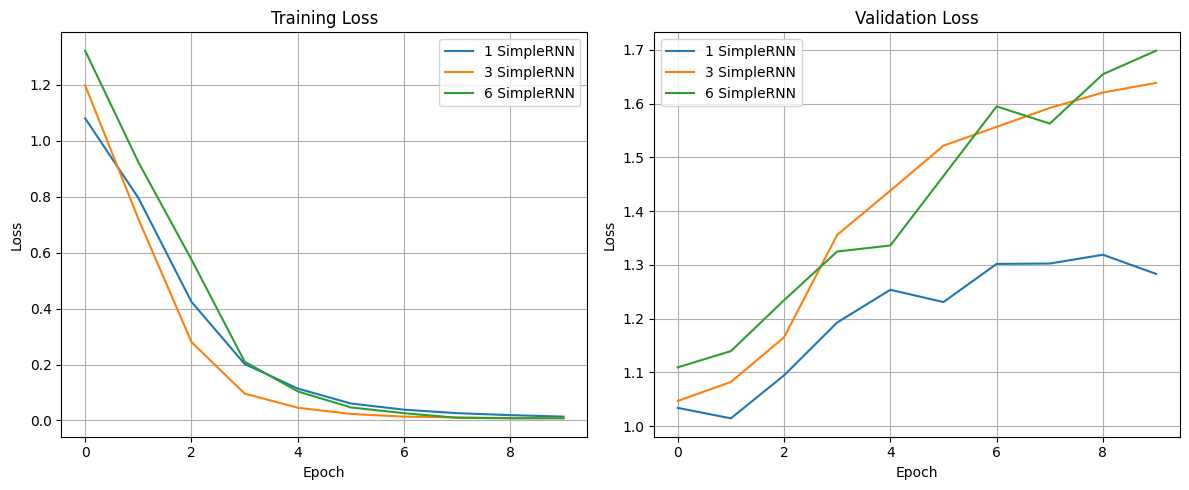

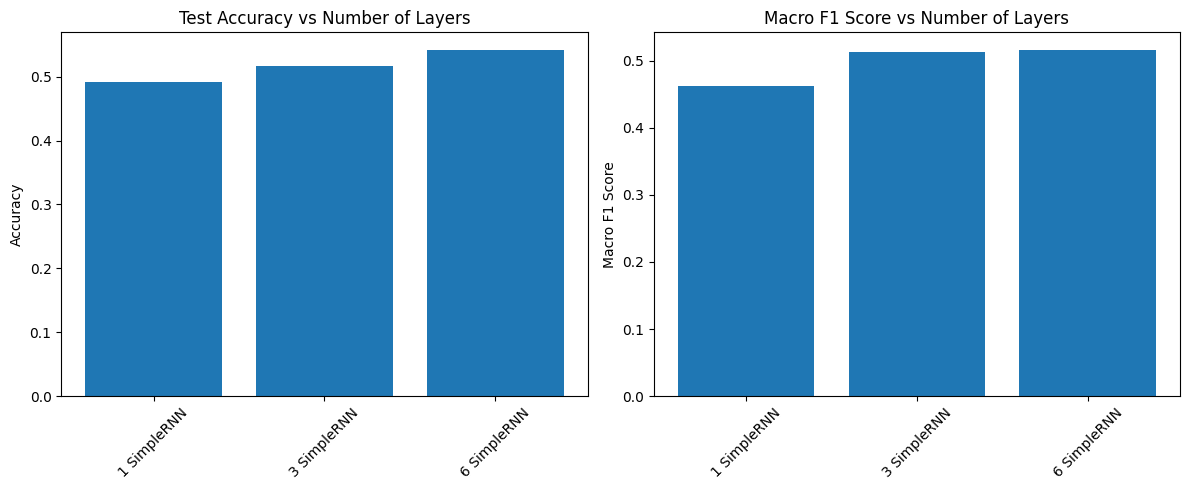

1 SimpleRNN:
  Accuracy: 0.4925
  F1 Score: 0.4620
3 SimpleRNN:
  Accuracy: 0.5175
  F1 Score: 0.5132
6 SimpleRNN:
  Accuracy: 0.5425
  F1 Score: 0.5168


In [9]:
epochs = 10
batch_size = 32

lay = {
    "1 SimpleRNN": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(64),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ],
    "3 SimpleRNN": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ],
    "6 SimpleRNN": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ]
}


accuracy = []
train_loss = {}
val_loss = {}
f1_scores = []

for name, layers in lay.items():
    
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    
    model = Sequential(layers)
    
    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer='adam',
        metrics=["accuracy"]
    )
    
    history = model.fit(
        np.array(train_texts, dtype=object),
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(np.array(val_texts, dtype=object), y_val),
        verbose=1,
        shuffle=True
    )
    
    train_loss[name] = history.history["loss"]
    val_loss[name] = history.history["val_loss"]
    
    score = model.evaluate(np.array(test_texts, dtype=object), y_test, verbose=0)
    accuracy.append(score[1])
    
    y_pred = model.predict(np.array(test_texts, dtype=object), verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    f1 = f1_score(y_test.flatten(), y_pred_classes, average='macro')
    f1_scores.append(f1)

# Plot training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, tl in train_loss.items():
    plt.plot(tl, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 2, 2)
for name, vl in val_loss.items():
    plt.plot(vl, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot accuracy comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
names = list(lay.keys())
plt.bar(names, accuracy)
plt.title("Test Accuracy vs Number of Layers")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)

# Plot F1 score comparison
plt.subplot(1, 2, 2)
plt.bar(names, f1_scores)
plt.title("Macro F1 Score vs Number of Layers")
plt.ylabel("Macro F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for name, acc, f1 in zip(names, accuracy, f1_scores):
    print(f"{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")

### Number of Cells

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.3549 - loss: 1.0989 - val_accuracy: 0.4500 - val_loss: 1.0360
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7402 - loss: 0.7871 - val_accuracy: 0.5500 - val_loss: 0.9571
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9257 - loss: 0.5421 - val_accuracy: 0.5400 - val_loss: 0.9657
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9598 - loss: 0.3554 - val_accuracy: 0.6100 - val_loss: 0.9030
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9897 - loss: 0.2048 - val_accuracy: 0.5700 - val_loss: 0.9224
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.1291 - val_accuracy: 0.5800 - val_loss: 1.0053
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0809 - val_accuracy: 0.5800 - val_loss: 1.0298
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9994 - loss: 0.0632 - val_accuracy: 0.5800 - v

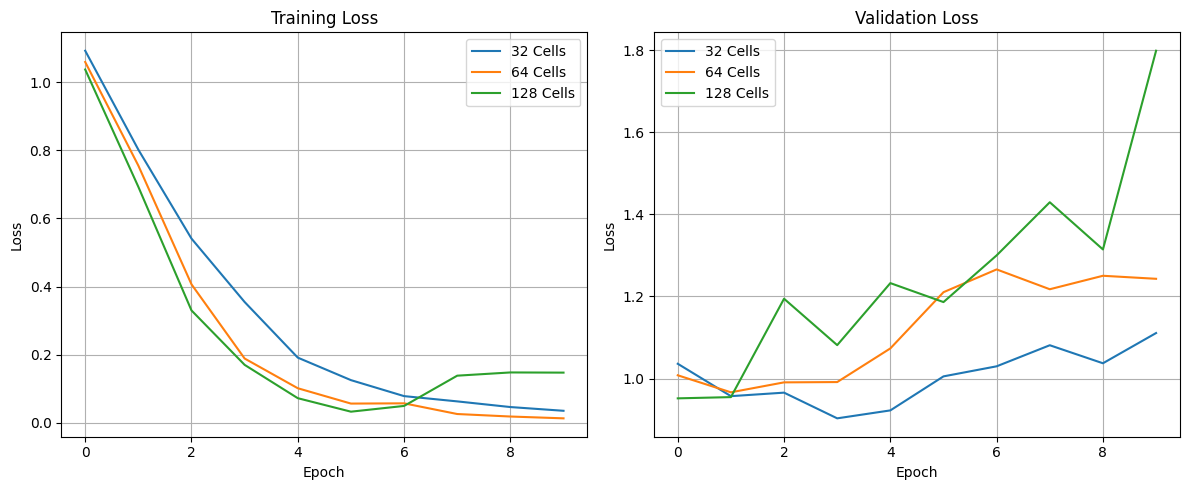

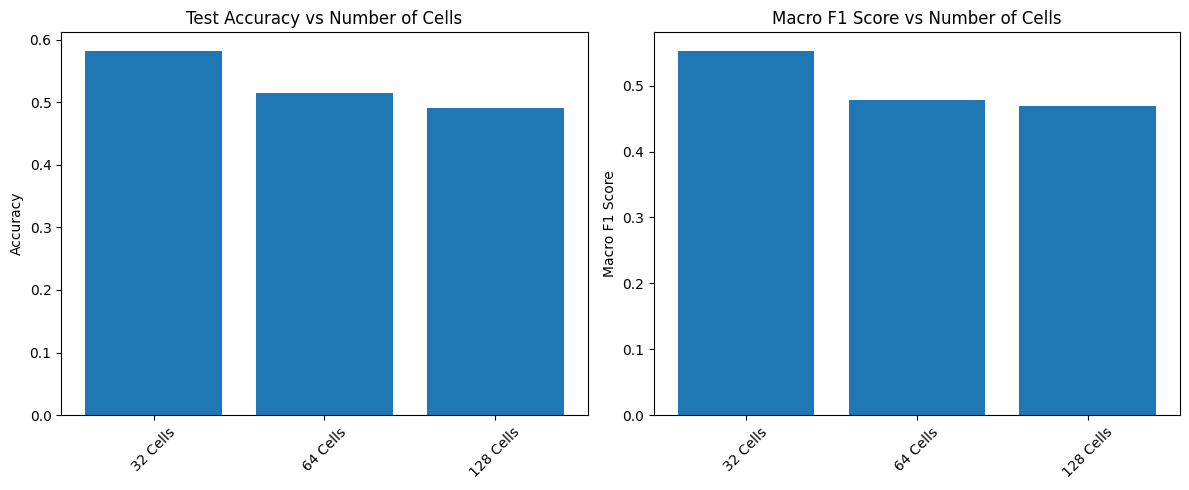

32 Cells:
  Accuracy: 0.5825
  F1 Score: 0.5532
64 Cells:
  Accuracy: 0.5150
  F1 Score: 0.4785
128 Cells:
  Accuracy: 0.4900
  F1 Score: 0.4689


In [4]:
epochs = 10
batch_size = 32

cells = {
    "32 Cells": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(32),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ],
    "64 Cells": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(64),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ],
    "128 Cells": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(128),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ]
}


accuracy = []
train_loss = {}
val_loss = {}
f1_scores = []

for name, layers in cells.items():
    
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    
    model = Sequential(layers)
    
    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer='adam',
        metrics=["accuracy"]
    )
    
    history = model.fit(
        np.array(train_texts, dtype=object),
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(np.array(val_texts, dtype=object), y_val),
        verbose=1,
        shuffle=True
    )
    
    train_loss[name] = history.history["loss"]
    val_loss[name] = history.history["val_loss"]
    
    score = model.evaluate(np.array(test_texts, dtype=object), y_test, verbose=0)
    accuracy.append(score[1])
    
    y_pred = model.predict(np.array(test_texts, dtype=object), verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    f1 = f1_score(y_test.flatten(), y_pred_classes, average='macro')
    f1_scores.append(f1)

# Plot training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, tl in train_loss.items():
    plt.plot(tl, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 2, 2)
for name, vl in val_loss.items():
    plt.plot(vl, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot accuracy comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
names = list(cells.keys())
plt.bar(names, accuracy)
plt.title("Test Accuracy vs Number of Cells")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)

# Plot F1 score comparison
plt.subplot(1, 2, 2)
plt.bar(names, f1_scores)
plt.title("Macro F1 Score vs Number of Cells")
plt.ylabel("Macro F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for name, acc, f1 in zip(names, accuracy, f1_scores):
    print(f"{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")

### Type of RNN

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3999 - loss: 1.0885 - val_accuracy: 0.5200 - val_loss: 0.9795
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7699 - loss: 0.7400 - val_accuracy: 0.5800 - val_loss: 0.9478
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9472 - loss: 0.4738 - val_accuracy: 0.5700 - val_loss: 0.8732
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9769 - loss: 0.2667 - val_accuracy: 0.5500 - val_loss: 0.8931
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.1469 - val_accuracy: 0.5400 - val_loss: 0.9481
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0788 - val_accuracy: 0.5600 - val_loss: 0.9521
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0457 - val_accuracy: 0.5200 - val_loss: 1.0401
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0239 - val_accuracy: 0.5200 - v

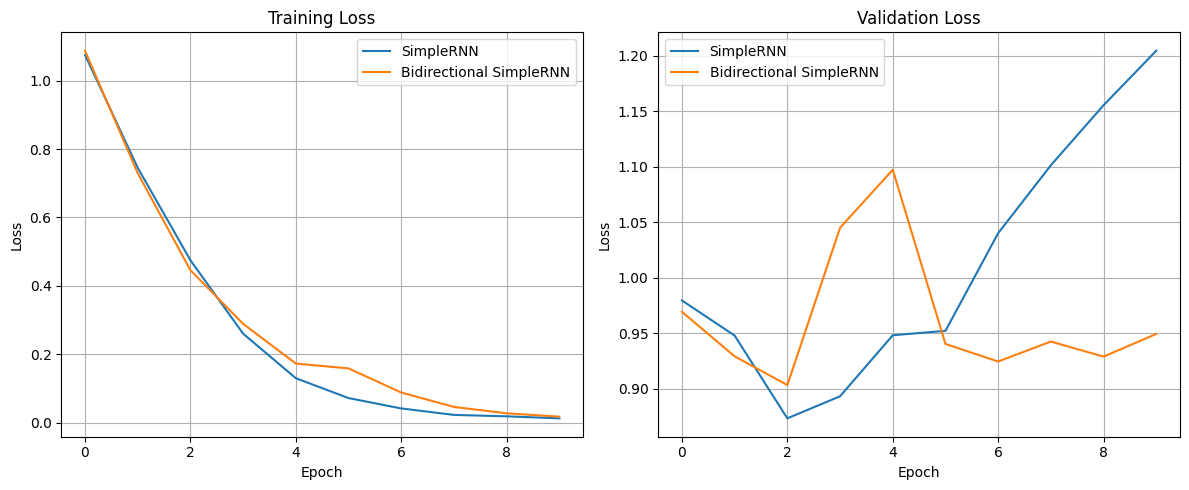

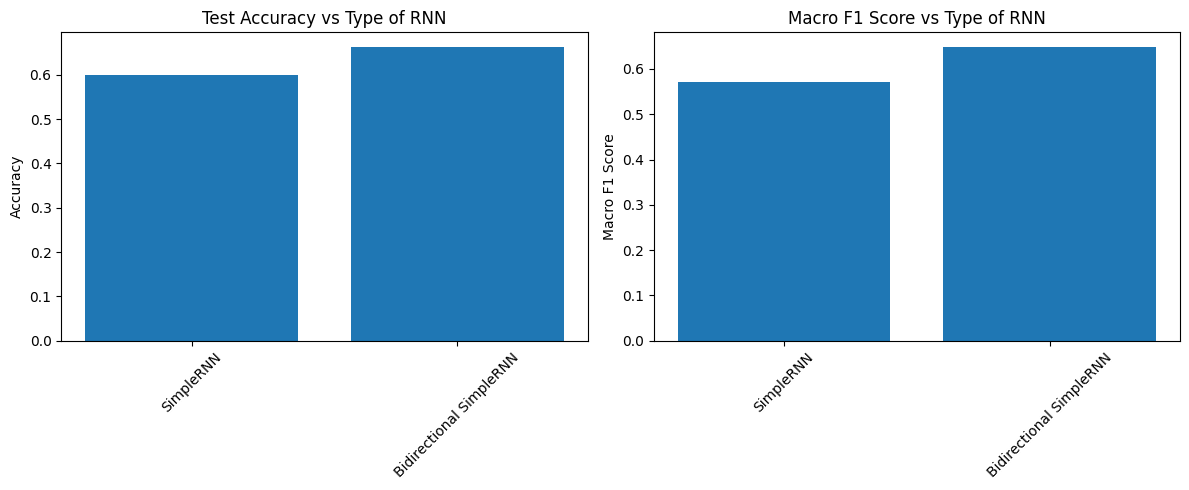

SimpleRNN:
  Accuracy: 0.6000
  F1 Score: 0.5705
Bidirectional SimpleRNN:
  Accuracy: 0.6625
  F1 Score: 0.6485


In [5]:
epochs = 10
batch_size = 32

rnn_types = {
    "SimpleRNN": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(64),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ],
    "Bidirectional SimpleRNN": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        Bidirectional(SimpleRNN(64)),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ]
}

accuracy = []
train_loss = {}
val_loss = {}
f1_scores = []

for name, layers in rnn_types.items():
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    
    model = Sequential(layers)
    
    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer='adam',
        metrics=["accuracy"]
    )
    
    history = model.fit(
        np.array(train_texts, dtype=object),
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(np.array(val_texts, dtype=object), y_val),
        verbose=1,
        shuffle=True
    )
    
    train_loss[name] = history.history["loss"]
    val_loss[name] = history.history["val_loss"]
    
    score = model.evaluate(np.array(test_texts, dtype=object), y_test, verbose=0)
    accuracy.append(score[1])
    
    y_pred = model.predict(np.array(test_texts, dtype=object), verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    f1 = f1_score(y_test.flatten(), y_pred_classes, average='macro')
    f1_scores.append(f1)
    
# Plot training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, tl in train_loss.items():
    plt.plot(tl, label=name)
    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 2, 2)
for name, vl in val_loss.items():
    plt.plot(vl, label=name)
    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot accuracy comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
names = list(rnn_types.keys())
plt.bar(names, accuracy)
plt.title("Test Accuracy vs Type of RNN")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)

# Plot F1 score comparison
plt.subplot(1, 2, 2)
plt.bar(names, f1_scores)
plt.title("Macro F1 Score vs Type of RNN")
plt.ylabel("Macro F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for name, acc, f1 in zip(names, accuracy, f1_scores):
    print(f"{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")

### Custom Forward RNN From Scratch

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3691 - loss: 1.1120 - val_accuracy: 0.5200 - val_loss: 1.0372
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7222 - loss: 0.8008 - val_accuracy: 0.5100 - val_loss: 1.0122
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9349 - loss: 0.4908 - val_accuracy: 0.4700 - val_loss: 1.1429
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9846 - loss: 0.2293 - val_accuracy: 0.5100 - val_loss: 1.1708
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9951 - loss: 0.0970 - val_accuracy: 0.5600 - val_loss: 1.0807
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0493 - val_accuracy: 0.5200 - val_loss: 1.2354
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0312 - val_accuracy: 0.5400 - val_loss: 1.2107
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0181 - val_accuracy: 0.5400 - v

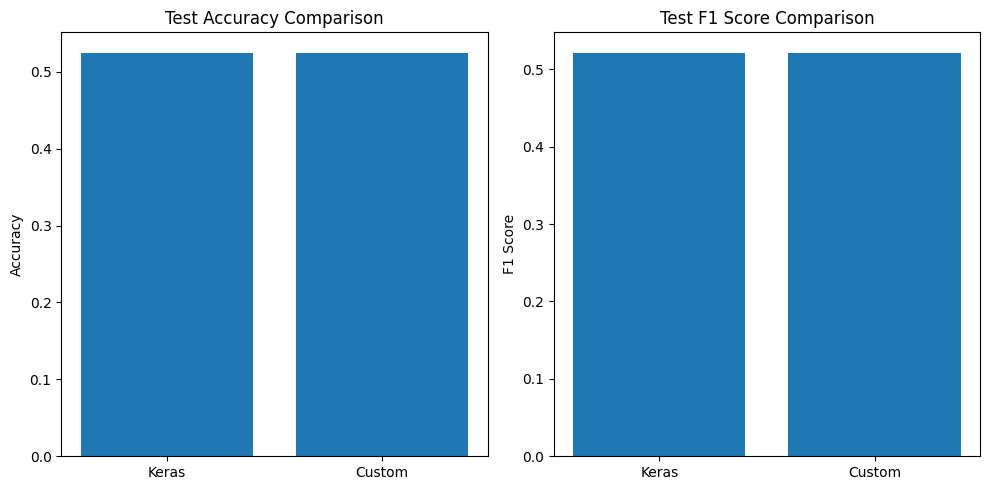

Test Accuracy: 0.5250
Custom Test Accuracy: 0.5250
Test F1 Score: 0.5215
Custom Test F1 Score: 0.5215


In [6]:
from src.rnn_lstm import RNNLSTMFromScratch

epochs = 10
batch_size = 32

accuracy = []
train_loss = {}
val_loss = {}
f1_scores = []

tf.random.set_seed(SEED)
np.random.seed(SEED)

model = Sequential([
    vectorizer,
    Embedding(input_dim=vocab_size + 1,
              output_dim=embedding_dim,
              mask_zero=True,
              embeddings_initializer='uniform'),
    SimpleRNN(64),
    Dropout(0.5, seed=SEED),
    Dense(len(label_map), 
          activation='softmax')
])

model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer='adam',
    metrics=["accuracy"]
)

history = model.fit(
    np.array(train_texts, dtype=object),
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(np.array(val_texts, dtype=object), y_val),
    verbose=1,
    shuffle=True
)

with open('../model/rnn.pkl', 'wb') as f:
    pickle.dump(model, f)

# Custom RNN model
custom_model = RNNLSTMFromScratch('../model/rnn.pkl')

def compare_metrics(keras_model, custom_model, X_test_raw, X_test_vectorized, y_test):
    """
    Compare metrics between Keras model and custom RNN model.
    :param keras_model: 
    :param custom_model: 
    :param X_test_raw: 
    :param X_test_vectorized: 
    :param y_test: 
    :return: 
    """
    keras_pred = keras_model.predict(X_test_raw, verbose=0)
    keras_classes = np.argmax(keras_pred, axis=1)
    
    custom_pred = custom_model.predict(X_test_vectorized)
    custom_classes = np.argmax(custom_pred, axis=1)
    
    # Calculate F1 score and accuracy
    keras_f1 = f1_score(y_test, keras_classes, average='weighted')
    custom_f1 = f1_score(y_test, custom_classes, average='weighted')
    keras_acc = accuracy_score(y_test, keras_classes)
    custom_acc = accuracy_score(y_test, custom_classes)
    
    return keras_f1, custom_f1, keras_acc, custom_acc

y_test = np.array([label_map[label] for label in test_labels])

keras_f1, custom_f1, keras_acc, custom_acc = compare_metrics(
    model, 
    custom_model, 
    np.array(test_texts, dtype=object),  
    vectorizer(test_texts),               
    y_test
)

# # Plot accuracy and f1 score
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Keras', 'Custom'], [keras_acc, custom_acc])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.subplot(1, 2, 2)
plt.bar(['Keras', 'Custom'], [keras_f1, custom_f1])
plt.title('Test F1 Score Comparison')
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()


# print accuracy and f1
print(f"Test Accuracy: {keras_acc:.4f}")
print(f"Custom Test Accuracy: {custom_acc:.4f}")
print(f"Test F1 Score: {keras_f1:.4f}")
print(f"Custom Test F1 Score: {custom_f1:.4f}")
